# Evaluating Timbral Extraction Methods on Real Data 👀🎵

In this Jupyter notebook, we will explore the hypothesis that the embedding method with the most structure in the TSNE (t-Distributed Stochastic Neighbor Embedding) space will yield the best similarity results, based on previously obtained TSNE results for various timbral extraction methods. 📊🔍

## Introduction

In this investigation, we will compare four different methods for feature extraction on audio data: MFCC (Mel-Frequency Cepstral Coefficients), Spectrogram, raw audio (used as a baseline), and a deep learning feature extraction method called "musicnn." 🎶🔬

## Methods

1. **MFCC**: Mel-Frequency Cepstral Coefficients are commonly used features for audio processing. They capture the spectral characteristics of audio signals, providing information about the frequency content over time.

2. **Spectrogram**: Spectrograms provide a visual representation of the frequencies present in an audio signal over time. They are created by performing a Fourier Transform on small overlapping windows of the audio signal.

3. **Raw Audio**: The raw audio waveform itself can be used as a baseline feature representation. It captures the amplitude values of the audio signal directly, without any additional processing.

4. **musicnn**: This deep learning feature extraction method is described in the paper titled "musicnn: Pretrained Convolutional Neural Networks for Music Audio Tagging" by Jordi Pons et al. [Link to paper](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwjqnu3Vi_H-AhXdFlkFHYXkBtgQFnoECBAQAQ&url=https%3A%2F%2Farxiv.org%2Fabs%2F1909.06654&usg=AOvVaw3JXWyJLxhkjoyz7lLg8mSO).

## Experimental Design

1. We will use a dataset of audio samples and cooresponding synthesizer paramters that produced those sounds.

2. Each audio sample will be processed using the four different feature extraction methods: MFCC, Spectrogram, raw audio, and musicnn.

3. We will pass in a target sound, obtain its timbre, and find the preset in the dataset with the nearest timbre based on cosine similarity.

4. Finally, we will evaluate and compare each timbral extraction method empirically to determine which method yields the closest sounding instrument.

## Expected Outcome

Based on our hypothesis, we expect that the embedding method with the most structure in the TSNE space will yield the best similarity results. By comparing the performance of the four feature extraction methods, we can gain insights into the effectiveness of each method for audio similarity analysis.

Let's proceed with the implementation and analysis to validate our hypothesis! 📊🔬🎵

## Imports

In [33]:
import sys; sys.path.append('../')
import librosa
import pandas as pd
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from src.utils import *
from IPython.display import Audio
from musicnn.extractor import extractor
from scipy.io.wavfile import write as wav_write


## Load a Target Sound Snippet

In [2]:
# specify the path to the dataset
dataset_path = 'target-dataset'
sample_name = 'bill-evans-piano.wav'
target_path = f'{dataset_path}{os.sep}{sample_name}'

# Load the target audio
target_audio, target_sr = librosa.load(target_path, sr=44100)

In [3]:
# play the target audio
Audio(target_audio, rate=target_sr)

### Find the Fundamental Frequency of the Target Audio

In [4]:
ff = get_fundamental_frequency(target_audio, target_sr)

Likely note: F4, likely frequency: 349.1941058508811


### Find which of C2, C3, C4 the FF is Closest to

In [5]:
closest_note = get_closest_note_from_ff(ff[1])
print(f'Closest note: {closest_note}')

Closest note: C4


## Load the Preset Dataset File

In [6]:
# specify the dataset path
dataset_path = '../dataset/preset_dataset_musicnn.pt'

# load and convert the dataset to a dataframe
dataset = pd.DataFrame(torch.load(dataset_path))

## Evaluate Raw Audio as Baseline

### Find Closest Preset to Target Based on Cosine Similarity

In [7]:
# define the comparison vectors
comparison_audio_set = np.stack(dataset['raw_audio'])
print(f'Comparison audio set shape: {comparison_audio_set.shape}')

Comparison audio set shape: (367,)


In [8]:
comparison_audio_set = np.stack([x[closest_note] for x in dataset['raw_audio']])
print(f'Comparison audio set shape: {comparison_audio_set.shape}')
print('Target audio shape: ', target_audio.shape)

Comparison audio set shape: (367, 132300)
Target audio shape:  (44100,)


In [9]:
# adapt the comparison audio set to the target audio if their lengths are not equal
if comparison_audio_set.shape[1] < target_audio.shape[0]:
    comparison_audio_set = np.pad(comparison_audio_set, ((0, 0), (0, target_audio.shape[0] - comparison_audio_set.shape[1])), 'constant', constant_values=0)
elif comparison_audio_set.shape[1] > target_audio.shape[0]:
    comparison_audio_set = comparison_audio_set[:, :target_audio.shape[0]]
print(f'Comparison audio set shape: {comparison_audio_set.shape}')
print(f'Target audio shape: {target_audio.shape}')

Comparison audio set shape: (367, 44100)
Target audio shape: (44100,)


In [10]:
# find where the cosine similarity is maximum
cosine_similarity_vector = get_cosine_similarity(comparison_audio_set, target_audio)
raw_idx = np.argmax(cosine_similarity_vector)
print(f'Raw index: {raw_idx}')

Raw index: 129


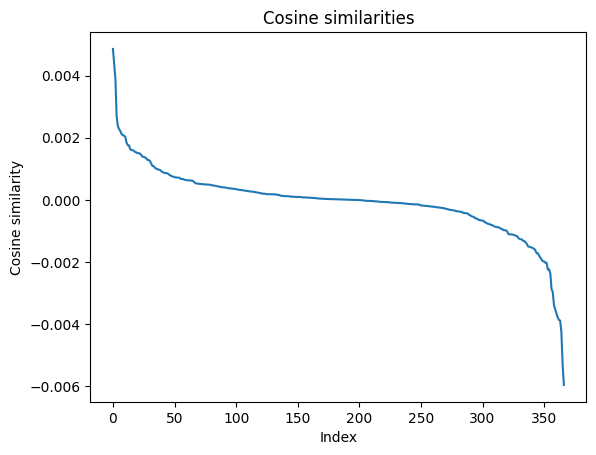

In [11]:
# plot the cosine similarity vector from highest to lowest
plt.plot(np.sort(cosine_similarity_vector)[::-1])
plt.title('Cosine similarities')
plt.xlabel('Index')
plt.ylabel('Cosine similarity')
plt.show()

In [12]:
# get the preset name
raw_audio_preset = dataset.iloc[raw_idx]['preset_names']
print(f'Raw audio preset: {raw_audio_preset}')

Raw audio preset: DRM Kick Drum 2 FMR


In [13]:
# play the audio assoicated with the preset
Audio(dataset.iloc[raw_idx]['raw_audio'][closest_note], rate=44100)

## Evaluate Spectrogram Timbral Feature

### Evaluate Cosine Similarity

In [14]:
test = np.stack([x[closest_note] for x in dataset['raw_audio']])
print(f'Test shape: {test.shape}')

Test shape: (367, 132300)


In [15]:
test = wav2spec(comparison_audio_set[0,:],target_sr)
print(f'Test shape: {test.shape}')

Test shape: (256, 44)


In [16]:
# Define the comparison vectors
comparison_spec_set = np.stack([wav2spec(x, 44100) for x in comparison_audio_set])
print(f'Comparison spec set shape: {comparison_spec_set.shape}')

Comparison spec set shape: (367, 256, 44)


In [17]:
# flatten the spectrogram set except for the first dimension
comparison_spec_set = comparison_spec_set.reshape(comparison_spec_set.shape[0], -1)
print(f'Comparison spec set shape: {comparison_spec_set.shape}')

Comparison spec set shape: (367, 11264)


In [18]:
# find where the cosine similarity is maximum
cosine_similarity_vector = get_cosine_similarity(comparison_spec_set, wav2spec(target_audio, 44100).reshape(-1))
spec_idx = np.argmax(cosine_similarity_vector)
print(f'Spec index: {spec_idx}')
print(f'Cosine similarity vector shape: {cosine_similarity_vector.shape}')
print(f'Highest Cosine similarity: {cosine_similarity_vector[spec_idx]}')

Spec index: 70
Cosine similarity vector shape: (367,)
Highest Cosine similarity: 0.05877009779214859


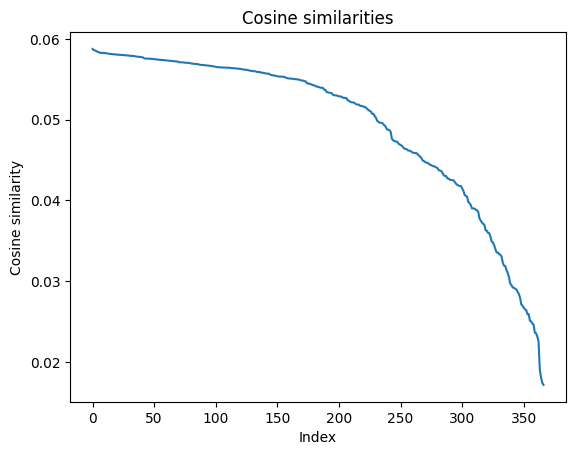

In [19]:
# plot the cosine similarity vector from highest to lowest
plt.plot(np.sort(cosine_similarity_vector)[::-1])
plt.title('Cosine similarities')
plt.xlabel('Index')
plt.ylabel('Cosine similarity')
plt.show()

In [20]:
# get the preset name
spec_preset = dataset.iloc[spec_idx]['preset_names']
print(f'Spec preset: {spec_preset}')

Spec preset: FN-Backwards ARP


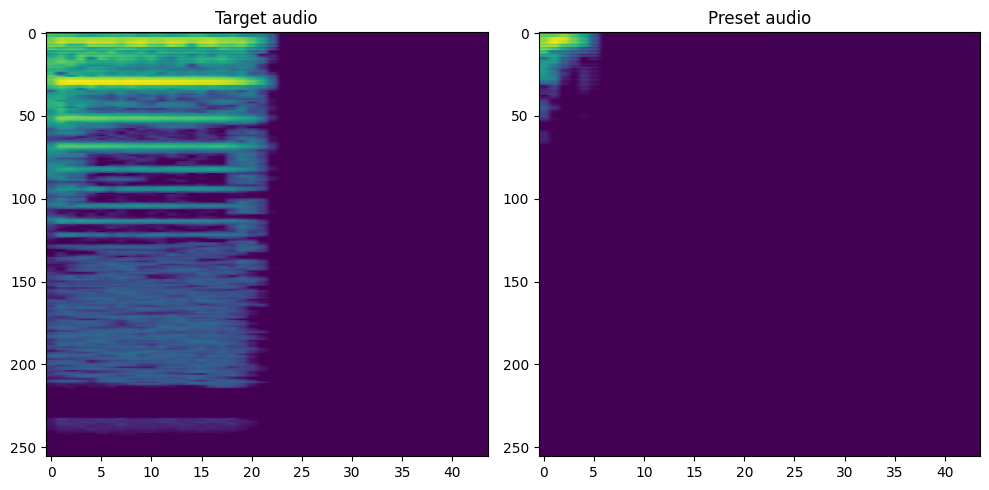

In [21]:
# compare the spectrogram of the target audio with the spectrogram of the preset using matplotlib
plt.figure(figsize=(10,5))
plt.subplot(1,2, 1)
plt.title('Target audio')
plt.imshow(wav2spec(target_audio, 44100),aspect='auto')
plt.subplot(1, 2, 2)
plt.title('Preset audio')
plt.imshow(wav2spec(dataset.iloc[spec_idx]['raw_audio'][closest_note].numpy()[:target_audio.shape[0]], 44100),aspect='auto')
plt.tight_layout()
plt.show()

In [22]:
# play the audio assoicated with the preset
Audio(dataset.iloc[spec_idx]['raw_audio']['C4'], rate=44100)

---
Overall, we can see that these results are not very good. This can largely be attributed to the fact that the note for our target sample is different than the notes present in the dataset. If we were to include all the notes across multiple scales in the preset dataset, it would be extremely large. Overall, this means that spectrograms are not good at determining timbral similarity between audio vectors because they are not pitch invariant. This is also confirmed by the extremely small cosine similarity plot shown above.

## Evaluate MFCC Timbral Feature

### Evaluate Cosine Simlarity

In [23]:
# define the comparison vectors
comparison_mfcc_set = np.stack([librosa.feature.mfcc(y=x, sr=44100) for x in comparison_audio_set])
print(f'Comparison mfcc set shape: {comparison_mfcc_set.shape}')

Comparison mfcc set shape: (367, 20, 87)


In [24]:
# convert the comparison set to a 2D array
comparison_mfcc_set = comparison_mfcc_set.reshape(comparison_mfcc_set.shape[0], -1)
print(f'Comparison mfcc set shape: {comparison_mfcc_set.shape}')

Comparison mfcc set shape: (367, 1740)


In [25]:
# find where the cosine similarity is maximum
cosine_similarity_vector = get_cosine_similarity(comparison_mfcc_set, librosa.feature.mfcc(y=target_audio, sr=44100).reshape(-1))
mfcc_idx = np.argmax(cosine_similarity_vector)
print(f'MFCC index: {mfcc_idx}')

MFCC index: 183


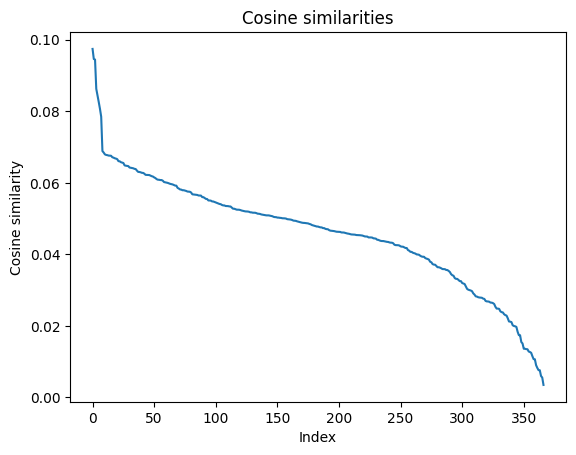

In [26]:
# plot the cosine similarity vector from highest to lowest
plt.plot(np.sort(cosine_similarity_vector)[::-1])
plt.title('Cosine similarities')
plt.xlabel('Index')
plt.ylabel('Cosine similarity')
plt.show()

In [27]:
# get the preset name
mfcc_preset = dataset.iloc[mfcc_idx]['preset_names']
print(f'MFCC preset: {mfcc_preset}')

MFCC preset: PAD Classic Sweep Pad FMR


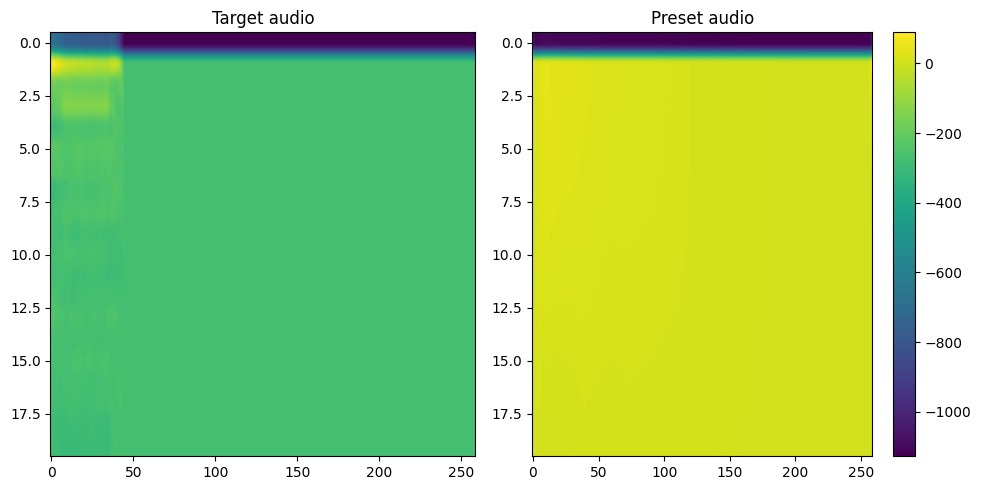

In [63]:
# visualize the MFCCs of the target audio and the preset
plt.figure(figsize=(10,5))
plt.subplot(1,2, 1)
plt.title('Target audio')
plt.imshow(librosa.feature.mfcc(y=target_audio, sr=44100),aspect='auto')
plt.subplot(1, 2, 2)
plt.title('Preset audio')
plt.imshow(librosa.feature.mfcc(y=dataset.iloc[mfcc_idx]['raw_audio'][closest_note].numpy()[:target_audio.shape[0]], sr=44100),aspect='auto')
# add a colorbar
plt.colorbar()
plt.tight_layout()

In [63]:
# play the audio assoicated with the preset
Audio(dataset.iloc[mfcc_idx]['raw_audio'][closest_note], rate=44100)

## Evalute musicnn Timbral Feature

### Evaluate Cosine Similarity

In [30]:
# define the comparison vectors
comparison_musicnn_set = np.stack(dataset['musicnn_features'])
print(f'Comparison musicnn set shape: {comparison_musicnn_set.shape}')

Comparison musicnn set shape: (367,)


In [31]:
# process the dataset so that it uses the closest note
comparison_musicnn_set = np.stack([x[closest_note] for x in comparison_musicnn_set])
print(f'Comparison musicnn set shape: {comparison_musicnn_set.shape}')

Comparison musicnn set shape: (367, 408)


In [32]:
# pad the target audio so that it is 3 seconds long
target_audio = np.pad(target_audio, (0, 132300 - target_audio.shape[0]), 'constant')
print(f'Target audio shape: {target_audio.shape}')

Target audio shape: (132300,)


In [39]:
# save the target audio as a temporary wav file
temp_file_name = 'temp_audio.wav'
wav_write(temp_file_name, 44100, target_audio)

In [58]:
# process the target audio through musicnn
taggram, tag, features = extractor(temp_file_name, model='MTT_musicnn', extract_features=True)
timbral_features = features['timbral'][0,:]
print(f'Features shape: {timbral_features.shape}')
print(f'Taggram shape: {taggram.shape}')

/Users/malek8/miniconda3/envs/gass/lib/python3.10/site-packages/musicnn/models.py:58: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  normalized_input = tf.compat.v1.layers.batch_normalization(expand_input, training=is_training)
/Users/malek8/miniconda3/envs/gass/lib/python3.10/site-packages/musicnn/models.py:103: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  conv = tf.compat.v1.layers.conv2d(inputs=inputs,
/Users/malek8/miniconda3/envs/gass/lib/python3.10/site-packages/musicnn/models.py:108: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` inst

Computing spectrogram (w/ librosa) and tags (w/ tensorflow).. done!
Features shape: (408,)
Taggram shape: (1, 50)


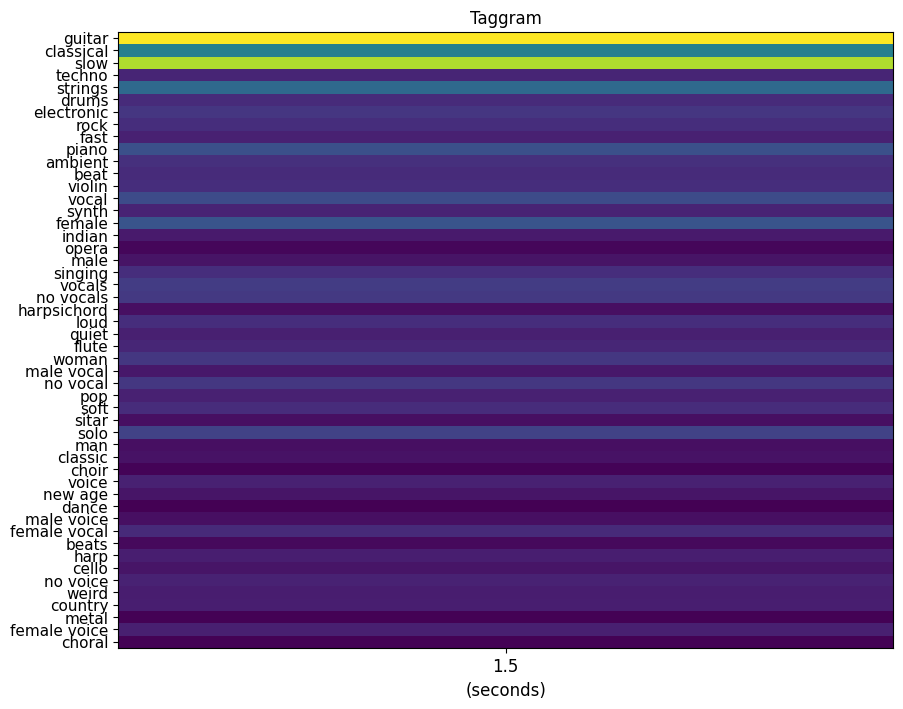

In [59]:
# visualize the taggram
in_length = 3 # seconds -- by default, the model takes inputs of 3 seconds with no overlap

# depict taggram
plt.rcParams["figure.figsize"] = (10,8)
fontsize=12
fig, ax = plt.subplots()
ax.imshow(taggram.T, interpolation=None, aspect="auto")

# title
ax.title.set_text('Taggram')
ax.title.set_fontsize(fontsize)

# x-axis title
ax.set_xlabel('(seconds)', fontsize=fontsize)

# y-axis
y_pos = np.arange(len(tag))
ax.set_yticks(y_pos)
ax.set_yticklabels(tag, fontsize=fontsize-1)

# x-axis
x_pos = np.arange(taggram.shape[0])
x_label = np.arange(in_length/2, in_length*taggram.shape[0], 3)
ax.set_xticks(x_pos)
ax.set_xticklabels(x_label, fontsize=fontsize)

plt.show()

In [48]:
# find where the cosine similarity is maximum
cosine_similarity_vector = get_cosine_similarity(comparison_musicnn_set, timbral_features)
musicnn_idx = np.argmax(cosine_similarity_vector)
print(f'Musicnn index: {musicnn_idx}')

Musicnn index: 121


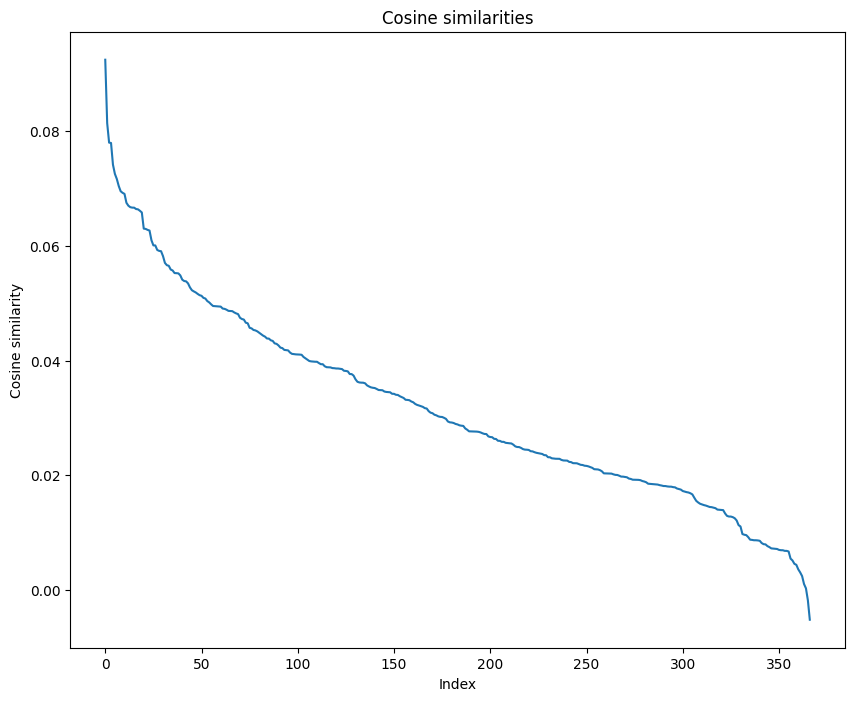

In [60]:
# visualize the cosine similarity vector
plt.plot(np.sort(cosine_similarity_vector)[::-1])
plt.title('Cosine similarities')
plt.xlabel('Index')
plt.ylabel('Cosine similarity')
plt.show()

In [50]:
# get the preset name
musicnn_preset = dataset.iloc[musicnn_idx]['preset_names']
print(f'Musicnn preset: {musicnn_preset}')

Musicnn preset: DRM Synth Drum 1 FMR


## Interactive Audio Playback Evaluation

In [ ]:
# import a play_audio function from a library for IPython.display


In [57]:
# play the target audio as well as the closest preset sound for each of the tested features
# Audio(target_audio, rate=44100)
# Audio(dataset.iloc[raw_idx]['raw_audio'][closest_note], rate=44100)
# Audio(dataset.iloc[spec_idx]['raw_audio'][closest_note], rate=44100)
Audio(dataset.iloc[mfcc_idx]['raw_audio'][closest_note], rate=44100)
# Audio(dataset.iloc[musicnn_idx]['raw_audio'][closest_note], rate=44100)